Dataset loaded with shape: (400, 3)
Columns in the dataset: ['Title', 'Subtitle', 'Product Description']
Filtered dataset shape: (155, 4)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Embedding: 100%|██████████| 155/155 [00:52<00:00,  2.96it/s]


Embeddings shape: (155, 768)
Explained variance ratio: [0.13252614 0.08628608]


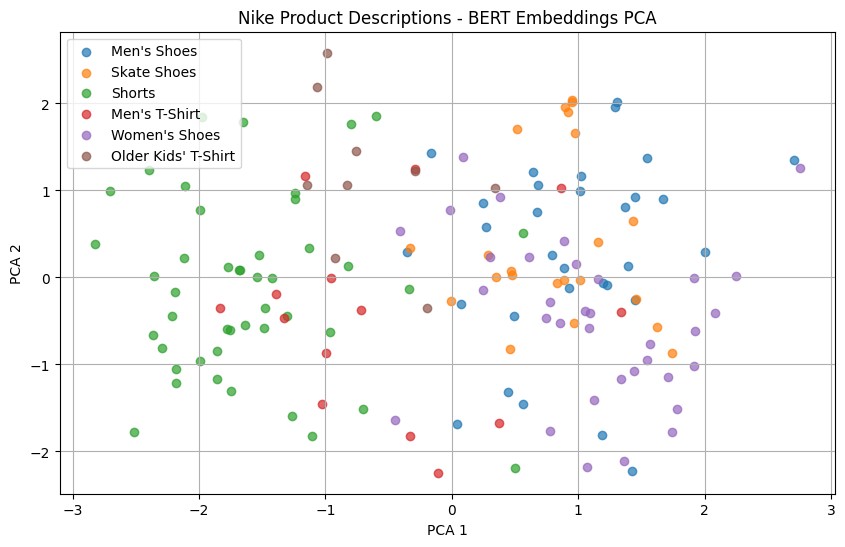

Saved filtered data and embeddings.


In [5]:
# 1) Install dependencies if needed
!pip install -q pandas scikit-learn matplotlib transformers tqdm

# 2) Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
from tqdm import tqdm
import torch

# 3) Load your dataset
df = pd.read_csv("NikeProductDescriptions.csv")
print("Dataset loaded with shape:", df.shape)
print("Columns in the dataset:", df.columns.tolist())

# 4) Filter subtitles as per assignment
keep_subtitles = [
    "Men's Shoes", "Men's T-Shirt", "Women's Shoes",
    "Skate Shoes", "Older Kids' T-Shirt"
]

def filter_subtitle(subtitle):
    if pd.isna(subtitle):
        return None
    if subtitle in keep_subtitles:
        return subtitle
    elif "Shorts" in subtitle:
        return "Shorts"
    else:
        return None

df["FilteredSubtitle"] = df["Subtitle"].apply(filter_subtitle)
df_filtered = df[df["FilteredSubtitle"].notnull()].copy()
print("Filtered dataset shape:", df_filtered.shape)

# 5) Initialize BERT model & tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()  # inference mode

# 6) Compute BERT embeddings for each description
embeddings = []
for desc in tqdm(df_filtered["Product Description"].astype(str).tolist(), desc="Embedding"):
    inputs = tokenizer(desc, return_tensors="pt", truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state.squeeze(0)  # shape (seq_len, hidden_size)
    embedding = last_hidden_state.mean(dim=0).cpu().numpy()  # average over tokens → (hidden_size,)
    embeddings.append(embedding)

embeddings = np.vstack(embeddings)  # shape: (num_products, hidden_size)
print("Embeddings shape:", embeddings.shape)

# 7) PCA to reduce to 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)
print("Explained variance ratio:", pca.explained_variance_ratio_)

# 8) Plot
plt.figure(figsize=(10, 6))
for subtitle in df_filtered["FilteredSubtitle"].unique():
    idx = df_filtered["FilteredSubtitle"] == subtitle
    plt.scatter(
        embeddings_2d[idx, 0], embeddings_2d[idx, 1],
        label=subtitle, alpha=0.7
    )
plt.legend()
plt.title("Nike Product Descriptions - BERT Embeddings PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

# 9) Save embeddings and filtered dataframe for GitHub upload
df_filtered.to_csv("filtered_nike_products.csv", index=False)
np.save("bert_embeddings.npy", embeddings)
print("Saved filtered data and embeddings.")
